In [2]:
# Remove all existing TensorFlow installations
#%pip uninstall -y tensorflow tensorflow-cpu tensorflow-gpu protobuf keras-ocr
#%pip cache purge

# Install specific versions with --no-deps to prevent auto-upgrades
#%pip install tensorflow-gpu==2.10.0 --no-deps
#%pip install tensorflow-cpu==2.10.0 --no-deps
#%pip install tensorflow==2.10.0 --no-deps
#%pip install protobuf==3.20.3 --no-deps
#%pip install keras-ocr==0.8.9
#%pip install python-Levenshtein
#%pip install pytesseract
#%pip install easyocr

In [3]:
# Ensure TensorFlow is imported correctly
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [4]:
import os
from difflib import SequenceMatcher
import Levenshtein
import time

# Directories
expected_output_directory = 'cleaned/000'
actual_output_directory = 'outputs/py_cleaned'

def cleanTextFile(text):
    return text.replace('\n', ' ')
    

# METHOD 1:
# Similarity percentage using Levenshtein distance (edit distance), more robust for OCR
# Levenshtein distance outputs how similar, not dis-similar
def calculate_similarity_lev(text1, text2):
    text1 = cleanTextFile(text1)
    text2 = cleanTextFile(text2)
    print(f"Text1: {text1}")
    print(f"Text2: {text2}")
    
    distance = Levenshtein.distance(text1, text2)
    max_length = max(len(text1), len(text2))
    if max_length == 0:  # Avoids dividing by zero
        return 100.0
    return (1 - distance / max_length) * 100

# METHOD 2:
def calculate_similarity(text1, text2): 
    return SequenceMatcher(None, text1, text2).ratio() * 100


def openCalculate(path):
    result = ''
    if os.path.exists(path):
                with open(path, 'r') as f:
                    result = f.read()
    return result

In [5]:
import cv2
from PIL import Image
import numpy as np

#NOT SURE ABOUT THIS
#def cleanImage(image):
#    # Convert PIL Image to numpy array if needed (NOT POSSIBLE WITH NORMAL CV2 SINCE PIL IMAGE)
#    if isinstance(image, Image.Image):
#        image = np.array(image)
#        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) #need for below
#    if len(image.shape) == 3:
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#
#    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
#    image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#    return image

def cleanImage(image, for_ocr):
    image = np.array(image)  # Convert to NumPy array
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    
    if for_ocr == "tesseract":
        image = cv2.GaussianBlur(image, (5, 5), 0)  # Reduce noise
        _, image = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY)  # Binarization
        return Image.fromarray(image)  # Convert back to PIL Image
    
    elif for_ocr == "keras":
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)  # Convert back to RGB
        return image  # Return NumPy array for Keras-OCR
    
    elif for_ocr == "easyocr":
        return image  # Keep as NumPy array
    
    else:
        raise ValueError("Invalid OCR type. Use 'tesseract', 'keras', or 'easyocr'.")


In [6]:
def loadDataAll(groundTruthDir, pyTesseractOutputTyped, pyTesseractOutputWritten, 
                kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten):
    count = 0
    pyTesseractTypedScore = 0
    pyTesseractWrittenScore = 0
    kerasOCRTypedScore = 0
    kerasOCRWrittenScore = 0
    easyOCRTypedScore = 0
    easyOCRWrittenScore = 0

    for filename in os.listdir(groundTruthDir):
        if filename.endswith('.txt'):
            # Construct file paths
            groundTruthPath = os.path.join(groundTruthDir, filename)
            pyTesseractTypedPath = os.path.join(pyTesseractOutputTyped, filename)
            pyTesseractWrittenPath = os.path.join(pyTesseractOutputWritten, filename)
            kerasOCRTypedPath = os.path.join(kerasOCROutputTyped, filename)
            kerasOCRWrittenPath = os.path.join(kerasOCROutputWritten, filename)
            easyOCRTypedPath = os.path.join(easyOCROutputTyped, filename)
            easyOCRWrittenPath = os.path.join(easyOCROutputWritten, filename)
    
            # Read file contents
            groundTruthText = openCalculate(groundTruthPath)
            pyTesseractTypedText = openCalculate(pyTesseractTypedPath)
            pyTesseractWrittenText = openCalculate(pyTesseractWrittenPath)
            kerasOCRTypedText = openCalculate(kerasOCRTypedPath)
            kerasOCRWrittenText = openCalculate(kerasOCRWrittenPath)
            easyOCRTypedText = openCalculate(easyOCRTypedPath)
            easyOCRWrittenText = openCalculate(easyOCRWrittenPath)

            # Calculate similarities
            pyTesseractTypedScoreLev = calculate_similarity_lev(pyTesseractTypedText, groundTruthText)
            pyTesseractWrittenScoreLev = calculate_similarity_lev(pyTesseractWrittenText, groundTruthText)
            kerasOCRTypedScoreLev = calculate_similarity_lev(kerasOCRTypedText, groundTruthText)
            kerasOCRWrittenScoreLev = calculate_similarity_lev(kerasOCRWrittenText, groundTruthText)
            easyOCRTypedScoreLev = calculate_similarity_lev(easyOCRTypedText, groundTruthText)
            easyOCRWrittenScoreLev = calculate_similarity_lev(easyOCRWrittenText, groundTruthText)
            
            print(f"File: {filename}")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {pyTesseractTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {pyTesseractWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {kerasOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {kerasOCRWrittenScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {easyOCRTypedScoreLev:.2f}%")
            print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {easyOCRWrittenScoreLev:.2f}%")
            
            # Accumulate scores
            count += 1
            pyTesseractTypedScore += pyTesseractTypedScoreLev
            pyTesseractWrittenScore += pyTesseractWrittenScoreLev
            kerasOCRTypedScore += kerasOCRTypedScoreLev
            kerasOCRWrittenScore += kerasOCRWrittenScoreLev
            easyOCRTypedScore += easyOCRTypedScoreLev
            easyOCRWrittenScore += easyOCRWrittenScoreLev            
        else:
            print(f"Expected output not found for {filename}")

    # Calculate averages and return results
    if count > 0:
        result = {
            "pytesseract Typed": pyTesseractTypedScore / count,
            "pytesseract Written": pyTesseractWrittenScore / count,
            "kerasOCR Typed": kerasOCRTypedScore / count,
            "kerasOCR Written": kerasOCRWrittenScore / count,
            "easyOCR Typed": easyOCRTypedScore / count,
            "easyOCR Written": easyOCRWrittenScore / count
        }
        return result
    else:
        return None

# PyTesseract

In [7]:
import pytesseract
from PIL import Image
import os

#Tesseract executable
pytesseract.pytesseract.tesseract_cmd = "C:/Program Files/Tesseract-OCR/tesseract.exe"

imageWritten = 'cleaned/000-written'
imageTyped = 'cleaned/000-typed'

def processImagesPyTesseract(imageDirectory, outputDirectory, process):
    pyTesseractTimes = {}
    for filename in os.listdir(imageDirectory):

        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            # Open using PIL (Need to open with RGB and not BGR)
            img = Image.open(image_path)
            if process:
                img = cleanImage(img, "tesseract") 

            # Output file format
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            # Run Tesseract and writes into output file
            with open(output_file, 'w') as f:
                startTime = time.time()
                text = pytesseract.image_to_string(img, config="--oem 3 --psm 6") #better for written notes (oem 3 is best OCR engine [LSTM + Legacy], psm 6 assumes block text) 
                endTime = time.time()
                pyTesseractTimes[filename] = endTime - startTime
                f.write(text)

            print(f"Text extracted from {filename} and saved to {output_file}")
    return pyTesseractTimes
#Uncomment to run PyTesseract on images
print("Processing images in directory (PyTesseract):", imageWritten)
pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWritten", False)
print("\nProcessing images in directory  (PyTesseract):", imageTyped)
pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTyped", False)


Processing images in directory (PyTesseract): cleaned/000-written
Text extracted from a01-000.png and saved to outputs/pyWritten/a01-000.txt
Text extracted from a01-003.png and saved to outputs/pyWritten/a01-003.txt
Text extracted from a01-007.png and saved to outputs/pyWritten/a01-007.txt
Text extracted from a01-011.png and saved to outputs/pyWritten/a01-011.txt
Text extracted from a01-014.png and saved to outputs/pyWritten/a01-014.txt
Text extracted from a01-020.png and saved to outputs/pyWritten/a01-020.txt
Text extracted from a01-026.png and saved to outputs/pyWritten/a01-026.txt
Text extracted from a01-030.png and saved to outputs/pyWritten/a01-030.txt
Text extracted from a01-043.png and saved to outputs/pyWritten/a01-043.txt
Text extracted from a01-049.png and saved to outputs/pyWritten/a01-049.txt
Text extracted from a01-049x.png and saved to outputs/pyWritten/a01-049x.txt
Text extracted from a01-053.png and saved to outputs/pyWritten/a01-053.txt
Text extracted from a01-058.png 

In [8]:
#Need to run and then restart the kernel to use

#%pip uninstall -y keras-ocr
#%pip install keras==2.10.0
#%pip install h5py==3.7.0
#%pip install efficientnet-tfkeras==1.1.1
#%pip install keras-ocr==0.8.9


In [9]:
import tensorflow as tf
import keras
import keras_ocr

# Print versions to verify
print(f"TensorFlow version: {tf.version.VERSION}")
print(f"Keras version: {keras.__version__}")

# Initialize pipeline
pipeline = keras_ocr.pipeline.Pipeline()
print("Pipeline initialized successfully!")

TensorFlow version: 2.10.0
Keras version: 2.10.0
Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
Pipeline initialized successfully!


# Keras-OCR

1/1 [==============================] - 2s 2s/step
Processing images in directory (Keras OCR): cleaned/000-written
2/2 [==============================] - 1s 594ms/step
Text extracted from a01-000.png and saved to outputs/kerasWritten/a01-000.txt
3/3 [==============================] - 2s 775ms/step
Text extracted from a01-003.png and saved to outputs/kerasWritten/a01-003.txt
3/3 [==============================] - 2s 590ms/step
Text extracted from a01-007.png and saved to outputs/kerasWritten/a01-007.txt
3/3 [==============================] - 2s 612ms/step
Text extracted from a01-011.png and saved to outputs/kerasWritten/a01-011.txt
2/2 [==============================] - 2s 870ms/step
Text extracted from a01-014.png and saved to outputs/kerasWritten/a01-014.txt
3/3 [==============================] - 2s 606ms/step
Text extracted from a01-020.png and saved to outputs/kerasWritten/a01-020.txt
3/3 [==============================] - 2s 781ms/step
Text extracted from a01-026.png and saved to ou

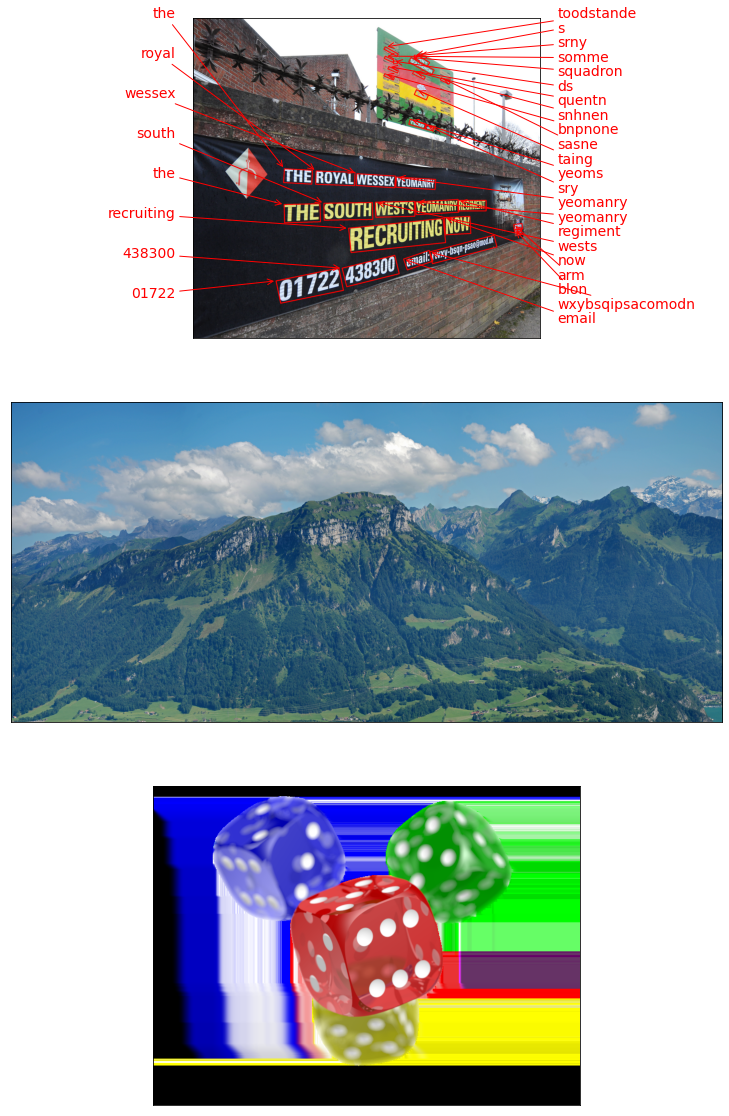

In [10]:
import matplotlib.pyplot as plt
import os
import keras_ocr

#EXAMPLE IMAGES
images = [
    keras_ocr.tools.read(url) for url in [
        'https://upload.wikimedia.org/wikipedia/commons/b/bd/Army_Reserves_Recruitment_Banner_MOD_45156284.jpg',
        'https://upload.wikimedia.org/wikipedia/commons/3/3f/Fronalpstock_big.jpg',  # Example replacement
        'https://upload.wikimedia.org/wikipedia/commons/4/47/PNG_transparency_demonstration_1.png'  # Example replacement
    ]
]
prediction_groups = pipeline.recognize(images)
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, predictions=predictions, ax=ax)


import numpy as np
# Process images using Keras OCR
def processImagesKerasOcr(imageDirectory, outputDirectory, process):
    kerasTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            img = Image.open(image_path).convert('RGB')
            if process:
                img = cleanImage(img, "keras") 
            else:
                img = np.array(img)  # Convert to numpy array (done in cleanImage)

            output_file = "outputs/" +outputDirectory+"/" +os.path.splitext(filename)[0] + '.txt'

            startTime = time.time()
            predictions = pipeline.recognize([img])[0]  # Get predictions for the image
            endTime = time.time()
            kerasTimes[filename] = endTime - startTime
            
            # Run Keras OCR and writes into output file
            with open(output_file, 'w') as f:
                for word, _ in predictions:
                    f.write(word + '\n')

            print(f"Text extracted from {filename} and saved to {output_file}")
    return kerasTimes

#Uncomment to run Keras OCR
print("Processing images in directory (Keras OCR):", imageWritten)
kerasWrittenTime=processImagesKerasOcr(imageWritten, "kerasWritten", False)
print("\nProcessing images in directory (Keras OCR):", imageTyped)
kerasTypedTime=processImagesKerasOcr(imageTyped, "kerasTyped", False)


# EasyOCR

In [11]:
#%pip uninstall -y easyocr opencv-python-headless
#%pip install --user easyocr

In [12]:
#Here's how to do it on Windows:
#Open the Start menu and search for "Environment Variables."
#Click on "Edit the system environment variables."
#In the System Properties window, click on the "Environment Variables" button.
#Under "User variables," find the Path variable and click "Edit."
#Add the directory Scripts as a new entry.
#Click "OK" to save and close all windows.
#Restart your terminal or IDE after making this change.
#eg C:\Users\adam4\AppData\Roaming\Python\Python39\Scripts\python.exe -m easyocr
#%pip install --upgrade Pillow
#%pip show Pillow

In [13]:
import easyocr
import os

reader = easyocr.Reader(['en'])

def processImagesEasyOcr(imageDirectory, outputDirectory, process):
    easyOCRTimes = {}
    for filename in os.listdir(imageDirectory):
        if filename.endswith('.png'):
            image_path = os.path.join(imageDirectory, filename)

            img = cv2.imread(image_path)
            if process:
                img = cleanImage(img, "easyocr")
                
            start = time.time()
            output = reader.readtext(img, detail=0)
            end = time.time()
            easyOCRTimes[filename] = end - start
            
            output_file ="outputs/"+outputDirectory+"/" + os.path.splitext(filename)[0] + '.txt'

            with open(output_file, 'w') as f:
                for line in output:
                    f.write(line + '\n')  

            print(f"Text for {filename} written to {output_file}")
    return easyOCRTimes

#uncomment to run Easy OCR
print("Processing images in directory (Easy OCR):", imageWritten)
easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWritten", False)
print("\nProcessing images in directory (Easy OCR):", imageTyped)
easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTyped", False)



Processing images in directory (Easy OCR): cleaned/000-written
Text for a01-000.png written to outputs/easy-ocrWritten/a01-000.txt
Text for a01-003.png written to outputs/easy-ocrWritten/a01-003.txt
Text for a01-007.png written to outputs/easy-ocrWritten/a01-007.txt
Text for a01-011.png written to outputs/easy-ocrWritten/a01-011.txt
Text for a01-014.png written to outputs/easy-ocrWritten/a01-014.txt
Text for a01-020.png written to outputs/easy-ocrWritten/a01-020.txt
Text for a01-026.png written to outputs/easy-ocrWritten/a01-026.txt
Text for a01-030.png written to outputs/easy-ocrWritten/a01-030.txt
Text for a01-043.png written to outputs/easy-ocrWritten/a01-043.txt
Text for a01-049.png written to outputs/easy-ocrWritten/a01-049.txt
Text for a01-049x.png written to outputs/easy-ocrWritten/a01-049x.txt
Text for a01-053.png written to outputs/easy-ocrWritten/a01-053.txt
Text for a01-058.png written to outputs/easy-ocrWritten/a01-058.txt
Text for a01-063.png written to outputs/easy-ocrWri

# Running Comparison

In [14]:
# Load the data and calculate similarity scores
groundTruth = 'cleaned/000-truth'
pyTesseractOutputTyped = 'outputs/pyTyped'
pyTesseractOutputWritten = 'outputs/pyWritten'
kerasOCROutputTyped = 'outputs/kerasTyped'
kerasOCROutputWritten = 'outputs/kerasWritten'
easyOCROutputTyped = 'outputs/easy-ocrTyped'
easyOCROutputWritten = 'outputs/easy-ocrWritten'
result = loadDataAll(groundTruth, pyTesseractOutputTyped, pyTesseractOutputWritten, kerasOCROutputTyped, kerasOCROutputWritten, easyOCROutputTyped, easyOCROutputWritten)
print("---------------------------------------------------")
print("Final Results")
print("---------------------------------------------------")
print(f"Similarity Percentage from Levenshtein with PyTesseract Typed: {result['pytesseract Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with PyTesseract Written: {result['pytesseract Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Typed: {result['kerasOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Keras OCR Written: {result['kerasOCR Written']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Typed: {result['easyOCR Typed']:.2f}%")
print(f"Similarity Percentage from Levenshtein with Easy OCR Written: {result['easyOCR Written']:.2f}%")
print("---------------------------------------------------") 

Text1: A MOVE to stop Mr. Gaitskell from nominating any more Labour life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, MP for ‘Manchester Exchange. 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for  Manchester Exhchange.
Text1: Ak MOVE to dtoe Mr. Gatbkell from  woMi natn mag OMA ORR, Labour Ufe_ Poors  Wo to BR wade aka medina af Labour MPs touorroo, Myr, Michael Toot Kar Pre Aown a vesotution ou Lhe  oudjedy On WO lo do GA backeR by Mer. Wit Gags , WP Lor Moncrade, Cxoranae , 
Text2: A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to  be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put down a resolution on the subject and he is to be

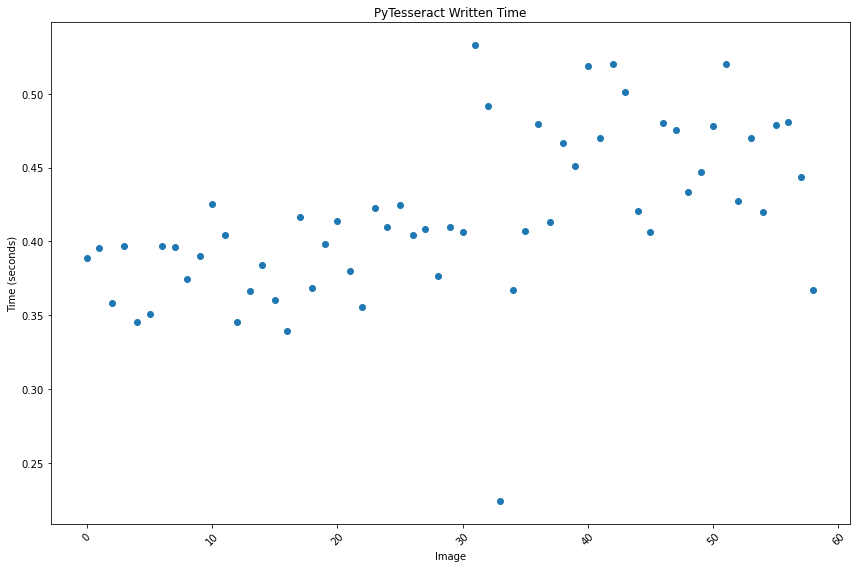

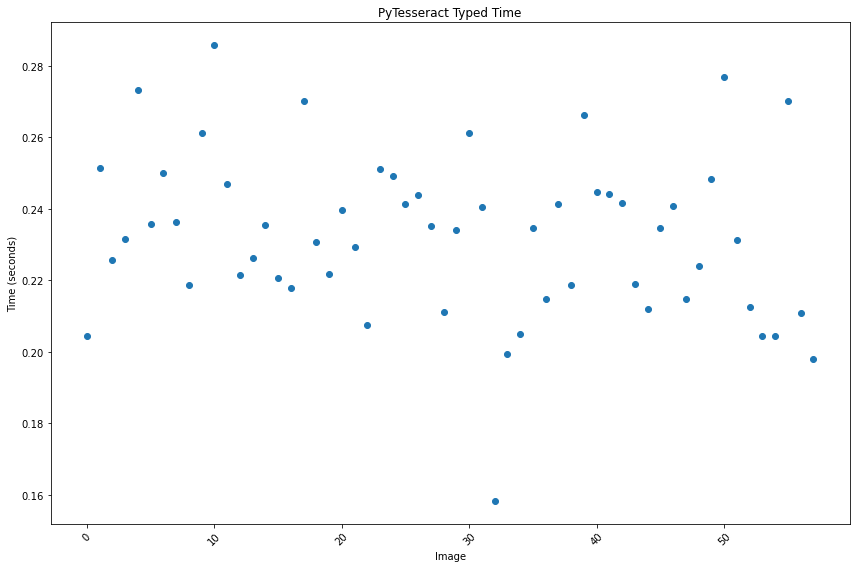

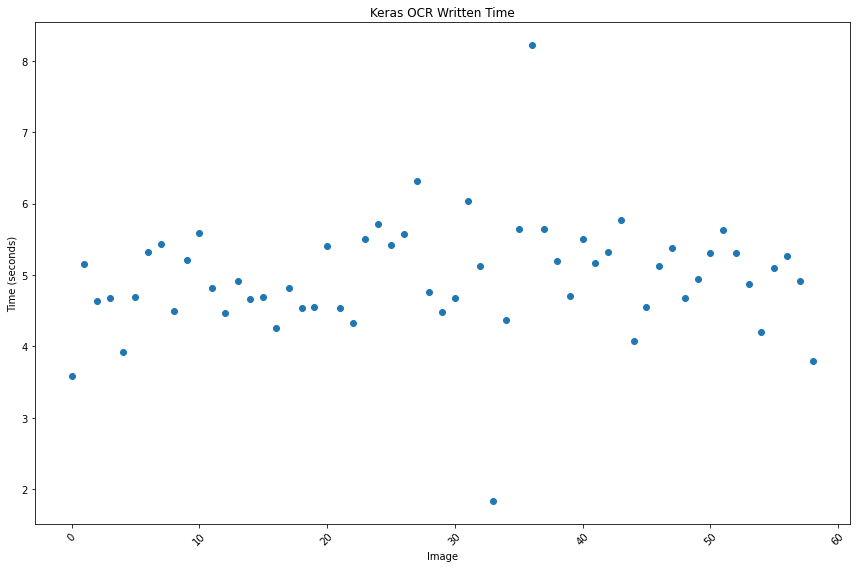

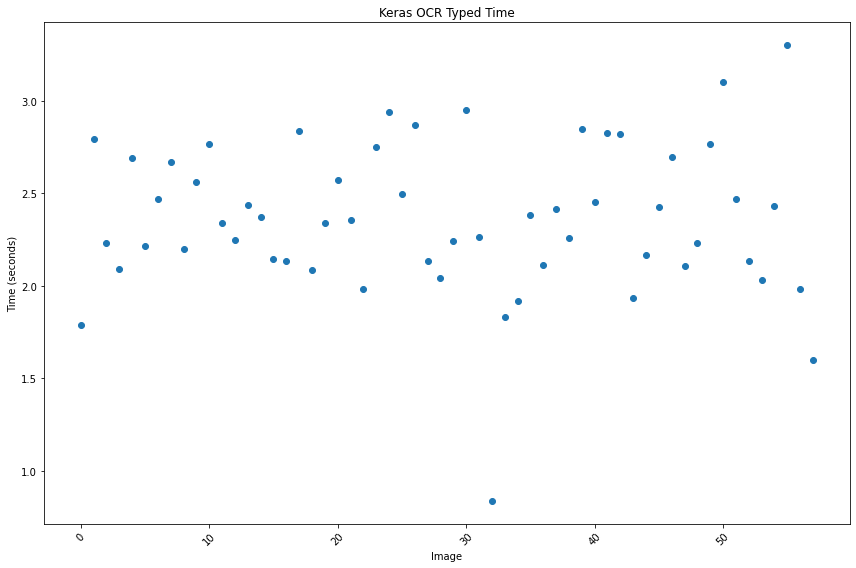

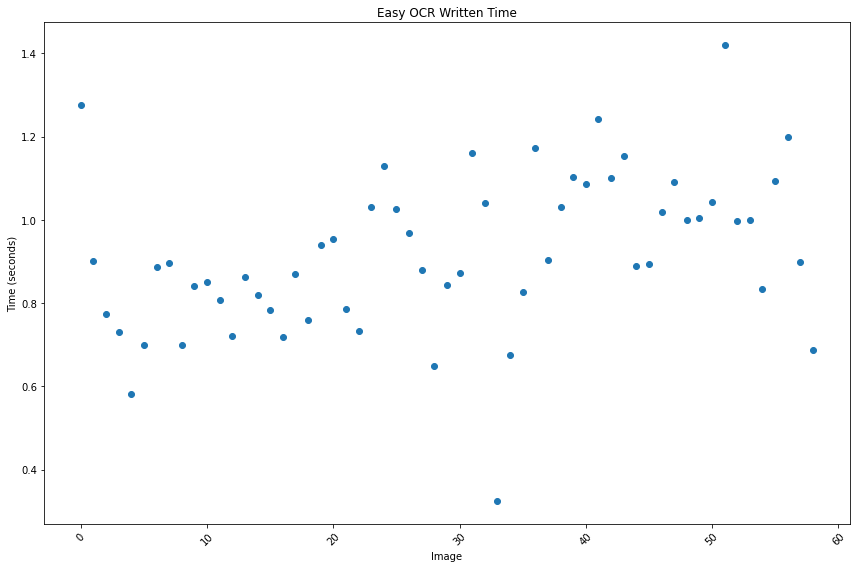

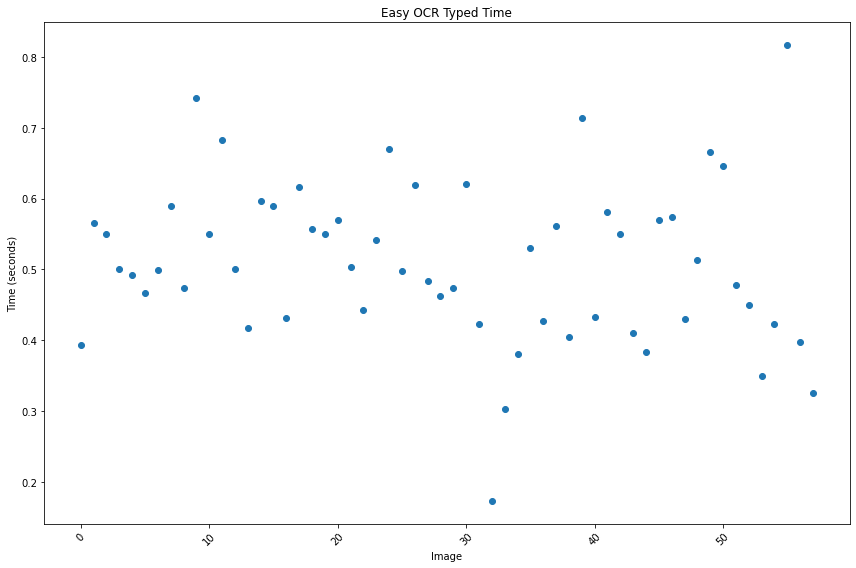

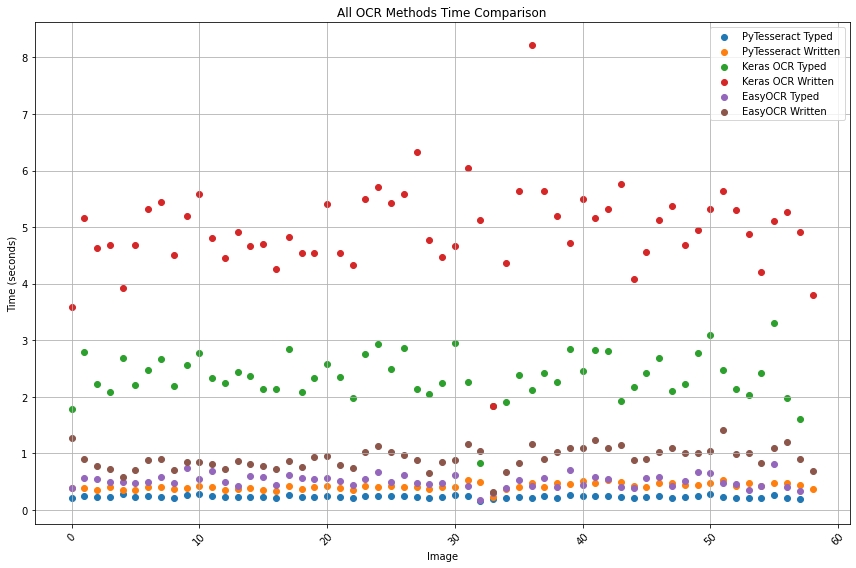

In [15]:
def plotTimes(times_dict, title):
    indices = range(len(times_dict))
    values = list(times_dict.values())
    plt.figure(figsize=(12, 8))
    plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plotAllTimes(lists, legend):
    plt.figure(figsize=(12, 8))
    for times_dict in lists:
        indices = range(len(times_dict))
        values = list(times_dict.values())
        plt.scatter(indices, values)
    plt.xlabel('Image')
    plt.ylabel('Time (seconds)')
    plt.title("All OCR Methods Time Comparison")
    plt.legend(legend, loc='upper right')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plotTimes(pyTesseractWrittenTime, "PyTesseract Written Time")
plotTimes(pyTesseractTypedTime, "PyTesseract Typed Time")
plotTimes(kerasWrittenTime, "Keras OCR Written Time")
plotTimes(kerasTypedTime, "Keras OCR Typed Time")
plotTimes(easyWrittenTime, "Easy OCR Written Time")
plotTimes(easyTypedTime, "Easy OCR Typed Time")

time_dicts = [pyTesseractTypedTime, pyTesseractWrittenTime, 
              kerasTypedTime, kerasWrittenTime,
              easyTypedTime, easyWrittenTime]

titles = ['PyTesseract Typed', 'PyTesseract Written',
          'Keras OCR Typed', 'Keras OCR Written',
          'EasyOCR Typed', 'EasyOCR Written']

plotAllTimes(time_dicts, titles)

In [16]:
#Clean data
print("Processing images in directory (PyTesseract):", imageWritten)
pyTesseractWrittenTime= processImagesPyTesseract(imageWritten, "pyWrittenCleaned", True)
print("\nProcessing images in directory  (PyTesseract):", imageTyped)
pyTesseractTypedTime=processImagesPyTesseract(imageTyped, "pyTypedCleaned", True)

print("Processing images in directory (Keras OCR):", imageWritten)
kerasWrittenTimeClean=processImagesKerasOcr(imageWritten, "kerasWrittenCleaned", True)
print("\nProcessing images in directory (Keras OCR):", imageTyped)
kerasTypedTimeClean=processImagesKerasOcr(imageTyped, "kerasTypedCleaned", True)

print("Processing images in directory (Easy OCR):", imageWritten)
easyWrittenTime=processImagesEasyOcr(imageWritten, "easy-ocrWrittenCleaned", True)
print("\nProcessing images in directory (Easy OCR):", imageTyped)
easyTypedTime=processImagesEasyOcr(imageTyped, "easy-ocrTypedCleaned", True)


groundTruth = 'cleaned/000-truth'
pyTesseractOutputTypedCleaned = 'outputs/pyTypedCleaned'
pyTesseractOutputWrittenCleaned = 'outputs/pyWrittenCleaned'
kerasOCROutputTypedCleaned = 'outputs/kerasTypedCleaned'
kerasOCROutputWrittenCleaned = 'outputs/kerasWrittenCleaned'
easyOCROutputTypedCleaned = 'outputs/easy-ocrTypedCleaned'
easyOCROutputWrittenCleaned = 'outputs/easy-ocrWrittenCleaned'
result = loadDataAll(groundTruth, pyTesseractOutputTypedCleaned, pyTesseractOutputWrittenCleaned, kerasOCROutputTypedCleaned, kerasOCROutputWrittenCleaned, easyOCROutputTypedCleaned, easyOCROutputWrittenCleaned)


Processing images in directory (PyTesseract): cleaned/000-written
Text extracted from a01-000.png and saved to outputs/pyWrittenCleaned/a01-000.txt
Text extracted from a01-003.png and saved to outputs/pyWrittenCleaned/a01-003.txt
Text extracted from a01-007.png and saved to outputs/pyWrittenCleaned/a01-007.txt
Text extracted from a01-011.png and saved to outputs/pyWrittenCleaned/a01-011.txt
Text extracted from a01-014.png and saved to outputs/pyWrittenCleaned/a01-014.txt
Text extracted from a01-020.png and saved to outputs/pyWrittenCleaned/a01-020.txt
Text extracted from a01-026.png and saved to outputs/pyWrittenCleaned/a01-026.txt
Text extracted from a01-030.png and saved to outputs/pyWrittenCleaned/a01-030.txt
Text extracted from a01-043.png and saved to outputs/pyWrittenCleaned/a01-043.txt
Text extracted from a01-049.png and saved to outputs/pyWrittenCleaned/a01-049.txt
Text extracted from a01-049x.png and saved to outputs/pyWrittenCleaned/a01-049x.txt
Text extracted from a01-053.pn

# Models

In [17]:
#PyTesseract
#Doesn't used a Deep learning model like EasyOCR

In [18]:
#Keras OCR
print(pipeline.detector.model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 basenet.slice1.0 (Conv2D)      (None, None, None,   1792        ['input_1[0][0]']                
                                64)                                                               
                                                                                                  
 basenet.slice1.1 (BatchNormali  (None, None, None,   256        ['basenet.slice1.0[0][0]']       
 zation)                        64)                                                         

In [19]:
print(pipeline.recognizer.model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 31, 200, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 permute (Permute)              (None, 200, 31, 1)   0           ['input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 200, 31, 1)   0           ['permute[0][0]']                
                                                                                                  
 conv_1 (Conv2D)                (None, 200, 31, 64)  640         ['lambda[0][0]']           

In [20]:
#Easy OCR
model = reader.recognizer 
print(model)

DataParallel(
  (module): Model(
    (FeatureExtraction): VGG_FeatureExtractor(
      (ConvNet): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU(inplace=True)
        (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (7): ReLU(inplace=True)
        (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (9): ReLU(inplace=True)
        (10): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
        (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_r

In [21]:
for name, param in model.named_parameters():
    print(name, param.shape)

module.FeatureExtraction.ConvNet.0.weight torch.Size([32, 1, 3, 3])
module.FeatureExtraction.ConvNet.0.bias torch.Size([32])
module.FeatureExtraction.ConvNet.3.weight torch.Size([64, 32, 3, 3])
module.FeatureExtraction.ConvNet.3.bias torch.Size([64])
module.FeatureExtraction.ConvNet.6.weight torch.Size([128, 64, 3, 3])
module.FeatureExtraction.ConvNet.6.bias torch.Size([128])
module.FeatureExtraction.ConvNet.8.weight torch.Size([128, 128, 3, 3])
module.FeatureExtraction.ConvNet.8.bias torch.Size([128])
module.FeatureExtraction.ConvNet.11.weight torch.Size([256, 128, 3, 3])
module.FeatureExtraction.ConvNet.12.weight torch.Size([256])
module.FeatureExtraction.ConvNet.12.bias torch.Size([256])
module.FeatureExtraction.ConvNet.14.weight torch.Size([256, 256, 3, 3])
module.FeatureExtraction.ConvNet.15.weight torch.Size([256])
module.FeatureExtraction.ConvNet.15.bias torch.Size([256])
module.FeatureExtraction.ConvNet.18.weight torch.Size([256, 256, 2, 2])
module.FeatureExtraction.ConvNet.18.

# Training Keras (with our dataset)

In [74]:
from tensorflow.keras.optimizers import Adam


def matchData(imageFolder, groundTruthFolder):
    imagesPath = []
    textsPath = []
    #Assumes they are in the same order in both and each exists in the other
    for image in os.listdir(imageFolder):
        imagesPath.append(imageFolder + "/" +image)
    for text in os.listdir(groundTruthFolder):
        textsPath.append(groundTruthFolder+"/" + text)
    return imagesPath, textsPath

testWritten = "cleaned/000-written-test"
testTyped = "cleaned/000-typed-test"
testTruth = "cleaned/000-typed-test"
trainWritten = "cleaned/000-written"
trainTyped = "cleaned/000-typed"
trainTruth = "cleaned/000-truth"

trainWrittenPath, trainTestPathW = matchData(trainWritten, trainTruth)
trainTypedPath, trainTestPathT = matchData(trainTyped, trainTruth)

# two different models
#writtenTrainingData = list(zip(trainWrittenPath,trainTestPathW))
#typedTrainingData = list(zip(trainTypedPath, trainTestPathT))

pipeline = keras_ocr.pipeline.Pipeline()

def loadImages(path, reSize = (535,100)): #REMEBER TO SIZE IMAGE AS NEEDED (had 128,32)
    images = []
    for image in path:
        img = (keras_ocr.tools.read(image))
        img = cv2.resize(img,reSize)
        images.append(img)
    return np.array(images) 

def loadText(path):
    labels = []
    for textPath in path:
        temp = openCalculate(textPath)
        temp = temp.replace("\n", "")
        labels.append(temp)
    print(labels)
    return np.array(labels)

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
def preprocess_labels(labels): #GPT
    encoder = LabelEncoder()
    encoded_labels = encoder.fit_transform(labels)  # Convert text labels to numerical values
    encoded_labels = to_categorical(encoded_labels)  # One-hot encode labels
    return np.array(encoded_labels, dtype=np.float32)

def trainPipeline(name, trainData, truthData, epochs, batchSize =8):
    pipeline = keras_ocr.pipeline.Pipeline()
    recognizer = pipeline.recognizer
    detector = pipeline.detector
    
    newModelR = recognizer.model
    newModelD = detector.model
    newModelR.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy')
    newModelD.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')

    images = loadImages(trainData)
    texts = loadText(truthData)
    texts_encoded = preprocess_labels(texts)

    # For detector, we will create binary labels (since it's a detection problem, assuming bounding boxes)
    detector_labels = np.ones((len(images), 1))  # You might want to adjust this depending on your model

    print(f"Number of images: {len(images)}")
    print(f"Number of texts: {len(texts)}")

    # Train the detector model
    newModelD.fit(images, detector_labels, epochs=epochs, batch_size=batchSize)
    newModelD.save(f"{name}Detector.h5")
    
    # Train the recognizer model
    newModelR.fit(images, texts_encoded, epochs=epochs, batch_size=batchSize)
    newModelR.save(f"{name}Recognizer.h5")

#need to finish
trainPipeline('writtenModel', trainWrittenPath, trainTestPathW, epochs=10, batchSize=8)
trainPipeline('typedModel', trainTypedPath, trainTestPathT, epochs=10, batchSize=8)


model = keras.models.load_model("writtenModel.h5")
pipeline = keras_ocr.pipeline.Pipeline(recognizer=model)
process = pipeline.recognize

#processImagesKerasOcr(testWritten, outputDirectory, process)
#FYI fix names here later and make it do for bothaa
#also add names for the output directories


Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
Looking for C:\Users\adam4\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\adam4\.keras-ocr\crnn_kurapan.h5
['A MOVE to stop Mr. Gaitskell from nominating any more Labour Life Peers is to be made at a meeting of Labour M Ps tomorrow. Mr. Michael Foot has put downa resolution on the subject and he is to be backed by Mr. Will Griffiths, M P for Manchester Exhchange.', 'Through they may gather some Left-wing support, a large majority of Labour M Ps are likely to turn down the Foot-Griffiths resolution. Mr. Foot\'s line will be that as Labour M Ps opposed the Government Bill which brought life peers into existence, they should not now put forward nominees. He believes that the House of Lords should be abolished and that Labour should not take any steps which would appear to "prop-up" an out-dated institution.', 'Since 1958, 13 Labour life Peers and Peeresses have been created.  Mos

InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/binary_crossentropy/mul_1/BroadcastGradientArgs' defined at (most recent call last):
    File "c:\Users\adam4\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\adam4\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "c:\Users\adam4\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
      self.io_loop.start()
    File "c:\Users\adam4\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\adam4\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\adam4\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\adam4\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 367, in dispatch_shell
      await result
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\adam4\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2863, in run_cell
      result = self._run_cell(
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2909, in _run_cell
      return runner(coro)
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3106, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3309, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\adam4\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\adam4\AppData\Local\Temp\ipykernel_13460\355381527.py", line 84, in <cell line: 84>
      trainPipeline('writtenModel', trainWrittenPath, trainTestPathW, epochs=10, batchSize=8)
    File "C:\Users\adam4\AppData\Local\Temp\ipykernel_13460\355381527.py", line 76, in trainPipeline
      newModelD.fit(images, detector_labels, epochs=epochs, batch_size=batchSize)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\adam4\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/binary_crossentropy/mul_1/BroadcastGradientArgs'
Incompatible shapes: [8,1] vs. [8,50,267,2]
	 [[{{node gradient_tape/binary_crossentropy/mul_1/BroadcastGradientArgs}}]] [Op:__inference_train_function_355727]